In [1]:
# =====================================================
# Project 2 — Traffic / Track / Object Classification
# Full ML pipeline: MLP and SVM
# =====================================================



In [2]:
# 1. Import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pickle
import joblib
import time

from skimage.io import imread
from skimage.transform import resize

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.utils import to_categorical

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8,5)


In [4]:
# 2. Dataset Paths

#from google.colab import drive
#drive.mount('/content/drive')

#DATA_DIR = "/content/drive/MyDrive/CS306_2025/Project2/database/dataset"
DATA_DIR = "dataset/"
CACHE_FILE = "dataset_cache.pkl"   # will save (images, labels, class_names) to speed up reloads
IMG_SIZE = (64, 64)        # image resize

print("DATA_DIR:", DATA_DIR)
print("Expecting subfolders:", os.listdir(DATA_DIR))


Mounted at /content/drive
DATA_DIR: /content/drive/MyDrive/CS306_2025/Project2/database/dataset
Expecting subfolders: ['green', 'slow', 'free', 'yellow', 'sheep', 'blocked']


In [5]:
# 3. Load images (with caching)
# This cell loads images (colors), resizes, and caches to disk for fast repeat runs.
# It will also produce class_names list in folder order.

def load_or_cache_dataset(data_dir=DATA_DIR, cache_file=CACHE_FILE, img_size=IMG_SIZE):
    if os.path.exists(cache_file):
        print(f"Loading cached dataset from {cache_file} ...")
        with open(cache_file, "rb") as f:
            images, labels, class_names = pickle.load(f)
        return images, labels, class_names

    class_names = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
    images = []
    labels = []
    print("Loading images from folders:", class_names)
    for idx, cls in enumerate(class_names):
        cls_path = os.path.join(data_dir, cls)
        file_list = os.listdir(cls_path)
        print(f"  Class {idx} = {cls}, {len(file_list)} files")
        for fname in tqdm(file_list, desc=f"Class {cls}", leave=False):
            fpath = os.path.join(cls_path, fname)
            try:
                img = imread(fpath)
                # Ensure RGB
                if img is None:
                    continue
                if img.ndim == 2:
                    img = np.stack([img]*3, axis=-1)
                if img.shape[2] == 4:
                    img = img[:, :, :3]
                # Resize
                img_rs = resize(img, img_size, anti_aliasing=True)
                images.append((img_rs * 255).astype(np.uint8))
                labels.append(idx)
            except Exception as e:
                # Skip bad files but print occasionally
                # print(f"Skipping {fpath}: {e}")
                continue

    images = np.array(images, dtype=np.uint8)
    labels = np.array(labels, dtype=np.int32)
    # Save cache
    with open(cache_file, "wb") as f:
        pickle.dump((images, labels, class_names), f)
    print(f"Saved cache to {cache_file}")
    return images, labels, class_names

# Run loader
start = time.time()
images, labels, class_names = load_or_cache_dataset()
print("Loaded images shape:", images.shape)
print("Unique classes:", len(class_names))
print("Time elapsed: %.1f s" % (time.time() - start))


Loading images from folders: ['blocked', 'free', 'green', 'sheep', 'slow', 'yellow']
  Class 0 = blocked, 128 files


  Class 1 = free, 253 files


  Class 2 = green, 74 files


  Class 3 = sheep, 72 files


  Class 4 = slow, 111 files


  Class 5 = yellow, 86 files


Saved cache to dataset_cache.pkl
Loaded images shape: (724, 64, 64, 3)
Unique classes: 6
Time elapsed: 88.4 s


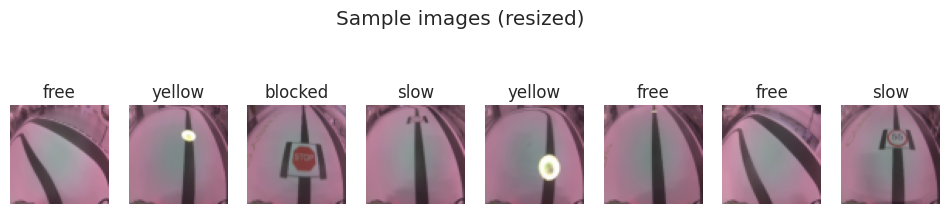

In [6]:
# Sample images
def show_samples(images, labels, class_names, n=8):
    idxs = np.random.choice(len(images), size=n, replace=False)
    plt.figure(figsize=(12,3))
    for i, idx in enumerate(idxs):
        plt.subplot(1, n, i+1)
        plt.imshow(images[idx])
        plt.title(class_names[labels[idx]])
        plt.axis('off')
    plt.suptitle("Sample images (resized)")
    plt.show()

show_samples(images, labels, class_names, n=8)


In [7]:
# 4. Flatten and Train/Test Split
#  - X_flat: flattened images for MLP and SVM
#  - X_norm: normalized images for potential CNN/other usage
X_flat = images.reshape((images.shape[0], -1)).astype(np.float32)  # n x (H*W*3)
X_norm = images.astype(np.float32) / 255.0

print("X_flat shape:", X_flat.shape)

# Split: train 70%, val 15%, test 15%
X_train, X_temp, y_train, y_temp = train_test_split(X_flat, labels, test_size=0.30, stratify=labels, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print("Train:", X_train.shape, y_train.shape)
print("Val:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)


X_flat shape: (724, 12288)
Train: (506, 12288) (506,)
Val: (109, 12288) (109,)
Test: (109, 12288) (109,)


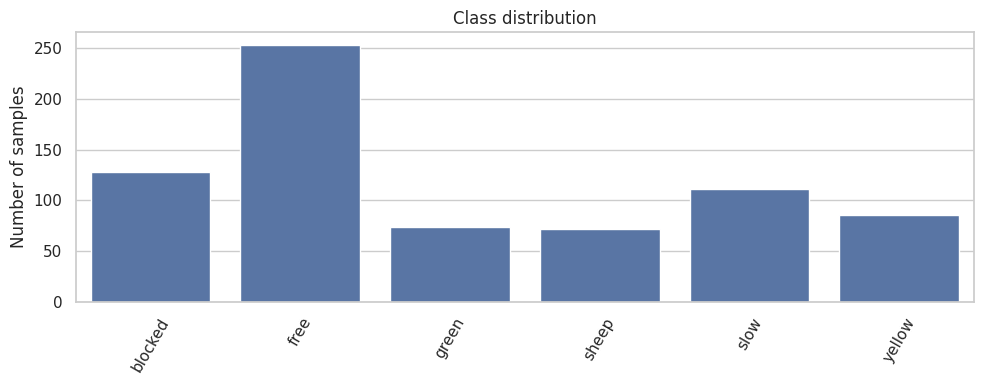

In [8]:
# Show class distribution (bar chart)
import pandas as pd
counts = pd.Series(labels).value_counts().sort_index()
plt.figure(figsize=(10,4))
sns.barplot(x=list(range(len(class_names))), y=counts.values)
plt.xticks(ticks=list(range(len(class_names))), labels=class_names, rotation=60)
plt.ylabel("Number of samples")
plt.title("Class distribution")
plt.tight_layout()
plt.show()


In [9]:
# 5. Preprocessing (Standardization)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s   = scaler.transform(X_val)
X_test_s  = scaler.transform(X_test)

print("Standardization complete.")


Standardization complete.


In [10]:
# 6. Model 1: MLP

num_classes = len(class_names)
input_dim = X_train_s.shape[1]

# Prepare labels for Keras (one-hot)
y_train_cat = to_categorical(y_train, num_classes)
y_val_cat = to_categorical(y_val, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

# Build MLP model
def build_mlp(input_dim, num_classes):
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

mlp_model = build_mlp(input_dim, num_classes)
mlp_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1024)           │    12,583,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,111,814 (50.02 MB)

 Trainable params: 13,111,814 (50.02 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Train MLP
es = callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

# convert inputs back to scaled flattened floats for Keras
X_train_keras = X_train_s
X_val_keras = X_val_s

start = time.time()
history = mlp_model.fit(X_train_keras, y_train_cat,
                        validation_data=(X_val_keras, y_val_cat),
                        epochs=100, batch_size=128, callbacks=[es], verbose=2)
print("MLP training time: %.1f s" % (time.time() - start))


Epoch 1/100
4/4 - 5s - 1s/step - accuracy: 0.4506 - loss: 4.4265 - val_accuracy: 0.6972 - val_loss: 2.5349
Epoch 2/100
4/4 - 3s - 866ms/step - accuracy: 0.6897 - loss: 4.5589 - val_accuracy: 0.7156 - val_loss: 2.4221
Epoch 3/100
4/4 - 4s - 885ms/step - accuracy: 0.7036 - loss: 4.2505 - val_accuracy: 0.7890 - val_loss: 1.3242
Epoch 4/100
4/4 - 3s - 667ms/step - accuracy: 0.7253 - loss: 3.3013 - val_accuracy: 0.7890 - val_loss: 2.1399
Epoch 5/100
4/4 - 3s - 638ms/step - accuracy: 0.7648 - loss: 3.4418 - val_accuracy: 0.8257 - val_loss: 1.5968
Epoch 6/100
4/4 - 2s - 421ms/step - accuracy: 0.7964 - loss: 2.4449 - val_accuracy: 0.8165 - val_loss: 1.5930
Epoch 7/100
4/4 - 3s - 733ms/step - accuracy: 0.7806 - loss: 2.4434 - val_accuracy: 0.7615 - val_loss: 2.2141
Epoch 8/100
4/4 - 2s - 450ms/step - accuracy: 0.8399 - loss: 2.1848 - val_accuracy: 0.8073 - val_loss: 1.8284
Epoch 9/100
4/4 - 1s - 324ms/step - accuracy: 0.8281 - loss: 2.0085 - val_accuracy: 0.7798 - val_loss: 1.6454
Epoch 10/100


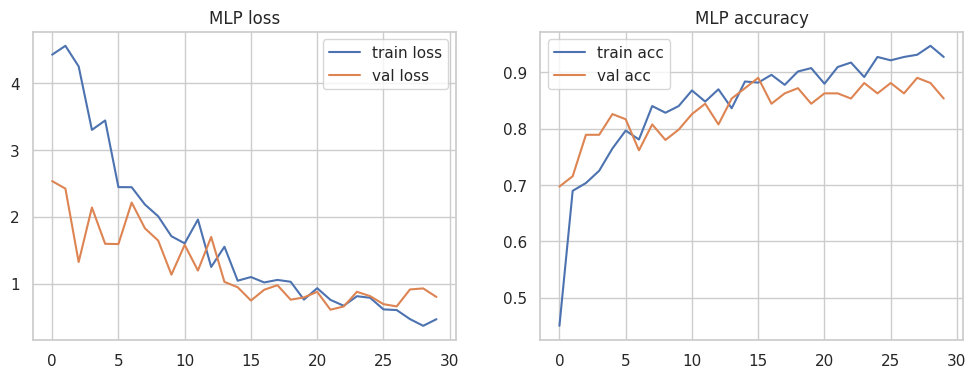

In [12]:
# Plot MLP training loss and val accuracy
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend(); plt.title("MLP loss")

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend(); plt.title("MLP accuracy")
plt.show()


In [13]:
# Evaluate MLP on validation and test sets
y_val_pred_mlp = mlp_model.predict(X_val_keras).argmax(axis=1)
print("MLP Validation accuracy:", accuracy_score(y_val, y_val_pred_mlp))
print(classification_report(y_val, y_val_pred_mlp, target_names=class_names))

# Final evaluation on test
X_test_keras = X_test_s
y_test_pred_mlp = mlp_model.predict(X_test_keras).argmax(axis=1)
print("MLP Test accuracy:", accuracy_score(y_test, y_test_pred_mlp))
print(classification_report(y_test, y_test_pred_mlp, target_names=class_names))


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
MLP Validation accuracy: 0.8623853211009175
              precision    recall  f1-score   support

     blocked       1.00      1.00      1.00        19
        free       0.86      0.82      0.84        38
       green       0.85      1.00      0.92        11
       sheep       0.62      0.73      0.67        11
        slow       0.84      0.94      0.89        17
      yellow       1.00      0.69      0.82        13

    accuracy                           0.86       109
   macro avg       0.86      0.86      0.85       109
weighted avg       0.87      0.86      0.86       109

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
MLP Test accuracy: 0.8807339449541285
              precision    recall  f1-score   support

     blocked       0.95      1.00      0.98        20
        free       0.86      0.82      0.84        38
       green       1.00      1.00      1.00        11
       sheep       0.53      0.73      0.62        11
        slow       1.00     

In [14]:
# Save the MLP model
mlp_model.save("mlp_model.h5")
print("Saved mlp_model.h5")


Saved mlp_model.h5


In [15]:
# 7. Model 2: SVM
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import time

# Directly use standardized flattened data
svm = SVC(kernel='rbf', C=10, gamma='scale', class_weight='balanced', random_state=42)

start = time.time()
svm.fit(X_train_s, y_train)
print("Training time: %.1f s" % (time.time() - start))

# Validation and test accuracy
y_val_pred_svm = svm.predict(X_val_s)
print("Validation accuracy:", accuracy_score(y_val, y_val_pred_svm))
print(classification_report(y_val, y_val_pred_svm, target_names=class_names))

y_test_pred_svm = svm.predict(X_test_s)
print("Test accuracy:", accuracy_score(y_test, y_test_pred_svm))
print(classification_report(y_test, y_test_pred_svm, target_names=class_names))


Training time: 6.8 s
Validation accuracy: 0.8990825688073395
              precision    recall  f1-score   support

     blocked       1.00      1.00      1.00        19
        free       0.89      0.84      0.86        38
       green       0.85      1.00      0.92        11
       sheep       0.69      0.82      0.75        11
        slow       0.94      1.00      0.97        17
      yellow       1.00      0.77      0.87        13

    accuracy                           0.90       109
   macro avg       0.90      0.90      0.90       109
weighted avg       0.91      0.90      0.90       109

Test accuracy: 0.9174311926605505
              precision    recall  f1-score   support

     blocked       1.00      1.00      1.00        20
        free       0.84      0.95      0.89        38
       green       1.00      1.00      1.00        11
       sheep       0.75      0.55      0.63        11
        slow       1.00      1.00      1.00        16
      yellow       1.00      0.85    

In [16]:
# Save PCA (scaler + svm)
from sklearn.pipeline import Pipeline
pipeline = Pipeline([
    ("scaler", scaler),
    ("svm", svm)
])
joblib.dump(pipeline, "svm_pipeline.joblib")
print("Saved pipeline to svm_pipeline.joblib")


Saved pipeline to svm_pipeline.joblib


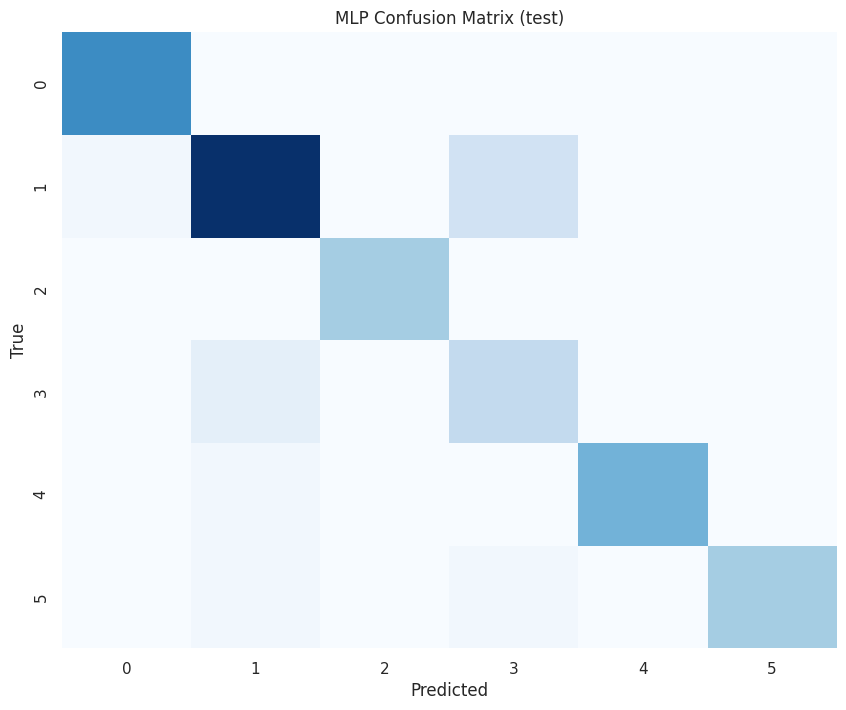

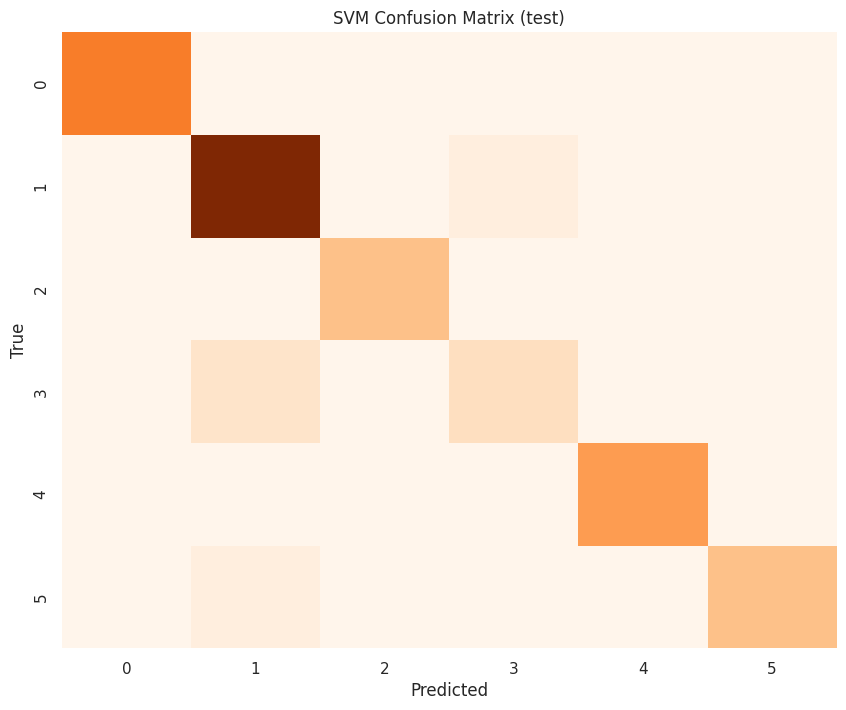

In [18]:
# 8. Final Test Evaluation - confusion matrices and visualizations
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

# MLP confusion matrix
cm_mlp = confusion_matrix(y_test, y_test_pred_mlp)
plt.figure(figsize=(10,8))
sns.heatmap(cm_mlp, cmap='Blues', cbar=False)
plt.title("MLP Confusion Matrix (test)")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()

# SVM confusion matrix
cm_svm = confusion_matrix(y_test, y_test_pred_svm)
plt.figure(figsize=(10,8))
sns.heatmap(cm_svm, cmap='Oranges', cbar=False)
plt.title("SVM Confusion Matrix (test)")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()


In [19]:
# Quick summary
print("=== SUMMARY ===")
print("MLP test accuracy:", accuracy_score(y_test, y_test_pred_mlp))
print("SVM test accuracy:", accuracy_score(y_test, y_test_pred_svm))


=== SUMMARY ===
MLP test accuracy: 0.8807339449541285
SVM test accuracy: 0.9174311926605505


In [20]:
# Save predictions and a small results CSV for easy viewing
res_df = pd.DataFrame({
    "true": y_test,
    "true_name": [class_names[i] for i in y_test],
    "mlp_pred": y_test_pred_mlp,
    "mlp_pred_name": [class_names[i] for i in y_test_pred_mlp],
    "svm_pred": y_test_pred_svm,
    "svm_pred_name": [class_names[i] for i in y_test_pred_svm]
})
res_df.to_csv("test_predictions.csv", index=False)
print("Saved test_predictions.csv")


Saved test_predictions.csv
